### Michelle Kouba
### DSC550 Week 5
### January 15, 2023

In [ ]:
# Import libraries
import pandas as pd
import string
from sklearn import metrics
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Import and inspect dataframe
movie_review_df = pd.read_csv('labeledTrainData.tsv',sep='\t')

### Creating the stemmed words/bag of words matrix for this week's assignment.

In [ ]:
## Finding the polarity and subjectivity of every review then categorizing it to match the sentiment score already provided
## for accuracy analysis.
# Function that gets the subjectivity of each review
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity
# Function that gets the polarity of each review
def get_polarity(text):
    return TextBlob(text).sentiment.polarity
# Function that sets a category/sentiment for each score
def get_analysis(score):
    if score < 0:
        return 'Negative'
    elif score >= 0:
        return 'Positive'
# Creates the variables named Subjectivity and Polarity that will be populated
# by the functions above
movie_review_df['Subjectivity'] = movie_review_df['review'].apply(get_subjectivity)
movie_review_df['Polarity'] = movie_review_df['review'].apply(get_polarity)
# Creates a variable that will store the sentiment for each review
movie_review_df['Sentiment_Analysis'] = movie_review_df['Polarity'].apply(get_analysis)

In [ ]:
## Checking the accuracy of the model with a confusion matrix
# Creating a Binary value to match to Sentiment
movie_review_df['Sentiment_Numeric'] = movie_review_df['Sentiment_Analysis'].replace({'Negative':0, 'Positive':1})
# Create confusion matrix with True Positives and True Negatives on the diagonal
confusion_matrix = pd.crosstab(movie_review_df.sentiment, movie_review_df.Sentiment_Numeric, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
# Print accuracy of the model
print(metrics.accuracy_score(movie_review_df.sentiment, movie_review_df.Sentiment_Numeric))


Predicted     0      1
Actual                
0          5307   7193
1           676  11824
0.68524


The accuracy of the model is roughly 69%.   We would expect the accuracy of random guessing to be around 50% so it's more accurate than random guessing.   The model seems to do a much better job accurately guessing positive reviews (roughly 94% correct) than negative reviews (roughly 42%). While the positive reviews are coded incredibly accurately, it would be better to go back and use random guessing for the negatively coded reviews instead.

### PART 2

In [ ]:
## Prepping the data for a custom model analyses by converting all the words in the review to lower-
## case letters, removing all punctuation and other characters, and stop words.
# Forces all words in the reviews to lower case
movie_review_df['cleaned_review'] = movie_review_df['review'].str.lower()
# Function that removes all punctuation
def remove_punctuation(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text
# Removing punctuation from each review
movie_review_df['cleaned_review'] = movie_review_df['cleaned_review'].apply(remove_punctuation)
# Function for removing stopwords
def remove_stopwords(text):
    ## Importing a list of stopwords:
    from nltk.corpus import stopwords
    stop = set(stopwords.words('english'))
    for word in text:
        if word in stop: text.replace(word, '')
    return text
# Removing stopwords
movie_review_df['cleaned_review'] = movie_review_df['cleaned_review'].apply(remove_stopwords)

In [ ]:
## Using NLTK's PorterStemmer to reduce the words to their stems.
# Importing need libraries/features
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
# Shortcut
ps = PorterStemmer()
# Functions that creates tokenized/stemmed words for easier matching and analysis.
def stem_sen(sentence):
    tokens = sentence.split()
    stem_tokens = [ps.stem(token) for token in tokens]
    return ' '.join(stem_tokens)
# Stemming words
movie_review_df['cleaned_review'] = movie_review_df['cleaned_review'].apply(stem_sen)

In [ ]:
## Creating a bag of words matrix from the stemmed text.
# Importing need libraries/features
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
# Creating the bag of words matrix
bows = count.fit_transform(movie_review_df['cleaned_review'])
# Checking the shape of the 'bag of words' matrix
bows.shape
# The number of rows match the original list of reviews (25,000).

(25000, 92407)

In [ ]:
## Creating a term frequency-inverse document frequency (tf-idf) matrix from the stemmed text.
# Importing need libraries/features
from sklearn.feature_extraction.text import TfidfVectorizer
# Shortcut
tfidf = TfidfVectorizer()
# Creating the tfidf matrix
feature_matrix = tfidf.fit_transform(movie_review_df['cleaned_review'])
feature_matrix.shape
# These dimensions match the 'bag of words' matrix.

(25000, 92407)

In [ ]:
# Splitting the stemmed words into a training and a test set.
# Splitting the dataset into the training set and the test set.
# Just selecting data for analysis
movie_split = movie_review_df[['sentiment', 'cleaned_review']].copy()
from sklearn.model_selection import train_test_split
train, test = train_test_split(movie_split, test_size = 0.2, random_state = 2000)
# Getting sentiment values
Y_train = train['sentiment'].values
Y_test = test['sentiment'].values

In [ ]:
# Fitting and applying the tf-idf vectorization to the training set (using fit_transform because it does both).
from sklearn.feature_extraction.text import TfidfVectorizer
# Applying and fitting the tf-idf vectorization to the training set stemmed values.
tdf = TfidfVectorizer(use_idf=True, max_df=0.95)
tdf.fit_transform(train['cleaned_review'].values)
train_feature_set = tdf.fit_transform(train['cleaned_review'].values)
# Setting X value for the training set for logistic regression
X_train = train_feature_set

In [ ]:
# Applying the tf-idf vectorization to the test set.
# We don't want to fit the data to the test set because we aren't
# training the test set, just the training set.  For the training set we are
# fitting and applying the tf-idf but for the test sets we are just applying the model.
test_feature_set = tdf.transform(test['cleaned_review'].values)
# Setting X value for the testing set for logistic regression
X_test = test_feature_set

In [ ]:
# Training a logistic regression using the training data.
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
log_reg_model = logistic_regression.fit(X_train,Y_train)

[LibLinear]

In [ ]:
# Finding the logistic regression model accuracy on the test set.
# Using the logistic regression performed on the training data to fit
# to the test data to see if it's an accurate model.
y_pred = logistic_regression.predict(X_test)

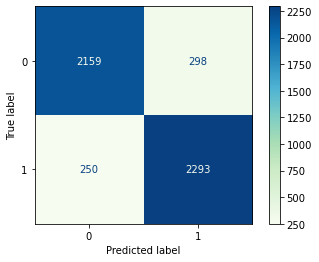

In [ ]:
# Creating a confusion matrix for the test set predictions.
confusion_matrix_log = metrics.plot_confusion_matrix(logistic_regression, X_test, Y_test, cmap = "GnBu")
print(confusion_matrix_log)

In [ ]:
# Calculating the accuracy of the logistic regression on the
# test model using TP and TN divided by total (accurate
# predictions divided by total predictions)
print('The accuracy of the model is:', round(metrics.accuracy_score(Y_test, y_pred),2)*100,'%')

The accuracy of the model is: 89.0 %


This model accurately predicts the sentiment of the movie review 89% of the time.  Given that 50% is randomly occuring and 100% is a perfect predictor, this model does a good job of predicting sentiment.

In [ ]:
# Collecting precision for the test set predictions (ratio of tp to
# all positives).  Ranges from 0 to 1 with 1 being the best.
print('The precision of the model is:', round(metrics.precision_score(Y_test, y_pred),2))

The precision of the model is: 0.88


In [ ]:
# Collecting the recall for the test set predictions (ratio of tp
# out of all tp and fn). Ranges from 0 to 1 with 1 being the best.
print('The recall score of the model is:', round(metrics.recall_score(Y_test, y_pred),2))

The recall score of the model is: 0.9


In [ ]:
# Collecting the F1 score for the test set predictions.
print('The F1 score of the model is:', round(metrics.f1_score(Y_test, y_pred),2))

The F1 score of the model is: 0.89


The precision, recall and F1 score of this model are all very high and nearly identical, showing that the training model is a good predictor of the test data and is a good model in general.

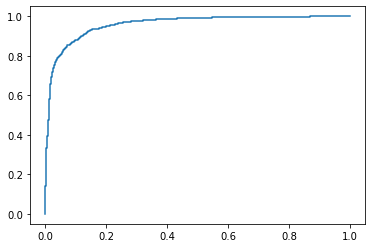

In [ ]:
# Creating a ROC curve for the test set.
y_pred_prob = logistic_regression.predict_proba(X_test)[:,1]
fpr, tpr, threshhold = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr,tpr)

In [ ]:
# Reporting the Area under the ROC curve (higher the better).
auc = metrics.roc_auc_score(Y_test, y_pred_prob)
print('The AUC is', round(auc*100),2)

The AUC is 96 2


An AUC of .962 states that the model is very good at predicting
sentiment.  For some reason my Python at home consistently doesn't print decimals (so I need to times by 100).   I'll look into this.

In [ ]:
# Running another classification model on the the data.
# Running a random forest model on the training data with 50 trees.
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 50, max_features='auto', random_state=44)
# Fitting the forest to the training set, using the stemmed words as
# features and the sentiment binary as the response variable
forest_model = forest.fit(X_train, Y_train)
# Fitting the training set to the testing model and getting predictions
# of sentiment on the test model from the model created from the training
# data.
y_pred = forest.predict(X_test)

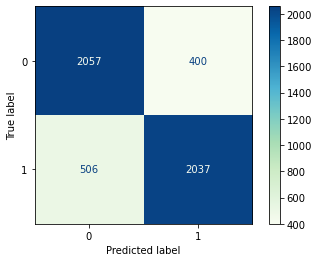

In [ ]:
# Creating a confusion matrix for the test set predictions (random forest).
confusion_matrix_log = metrics.plot_confusion_matrix(forest, X_test, Y_test, cmap = "GnBu")
print(confusion_matrix_log)

In [ ]:
# Calculating the accuracy of the random forest model of the
# test data using TP and TN divided by total (accurate
# predictions divided by total predictions)
print('The accuracy of the model is:', round(metrics.accuracy_score(Y_test, y_pred),2)*100,'%')

The accuracy of the model is: 82.0 %


This model accurately predicts the sentiment of the movie review 82% of the time.  Given that 50% is randomly occuring and 100% is a perfect predictor, this random forest model does a good job of predicting sentiment, but not as good as the logistic regression model did.

In [ ]:
# Collecting precision for the test set predictions (ratio of tp to
# all positives).  Ranges from 0 to 1 with 1 being the best.
print('The precision of the model is:', round(metrics.precision_score(Y_test, y_pred),2))

The precision of the model is: 0.84


In [ ]:
# Collecting the recall for the test set predictions (ratio of tp
# out of all tp and fn). Ranges from 0 to 1 with 1 being the best.
print('The recall score of the model is:', round(metrics.recall_score(Y_test, y_pred),2))

The recall score of the model is: 0.8


In [ ]:
# Collecting the F1 score for the test set predictions.
print('The F1 score of the model is:', round(metrics.f1_score(Y_test, y_pred),2))

The F1 score of the model is: 0.82


The precision, recall and F1 score of this model are all very high and nearly identical, showing that the training model from the random forest analysis is a good predictor of the test data and is a good model in general, but not as good as the logistic regression model.

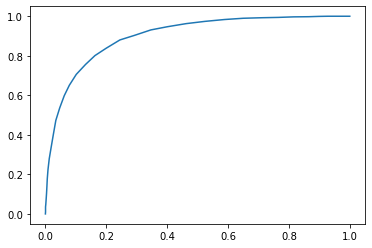

In [ ]:
# Creating a ROC curve for the test set.
y_pred_prob = forest.predict_proba(X_test)[:,1]
fpr, tpr, threshhold = metrics.roc_curve(Y_test, y_pred_prob)
plt.plot(fpr,tpr)

In [ ]:
# Reporting the Area under the ROC curve (higher the better).
auc = metrics.roc_auc_score(Y_test, y_pred_prob)
print('The AUC is', round(auc*100),2)

The AUC is 90 2


An AUC of .902 states that the model is very good at predicting
sentiment but not as good as the logistic regression model, similar to all the above findings.